# Inputs loading

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [4]:
%cd /Users/fedor.grigoryev/mycode

/Users/fedor.grigoryev/mycode


In [5]:
tcga_directory = '~/projs/tcga/data/cohorts'

expanded_directory = os.path.expanduser(tcga_directory)
cohorts = os.listdir(expanded_directory)
cohorts = [file for file in cohorts if not file.startswith('.')]
cohorts = [coh for coh in cohorts if coh != 'TARGET-NBL'] 

In [6]:
def goi_cohort_profiling(cohorts, goi):
    agggs = []
    
    for coh in tqdm(cohorts): 
        qc = pd.read_csv(f'{expanded_directory}/{coh}/qc.tsv', sep='\t', index_col=0)
        file_anot = pd.read_csv(f'{expanded_directory}/{coh}/file_annotation.tsv', sep='\t', index_col=0)
        tpm = pd.read_csv(f'{expanded_directory}/{coh}/tpm.tsv', sep='\t', index_col=0)
        tpm = np.log2(tpm + 1)
        
        qc_index = qc[qc['qc_passed_flag']].index
        tpm = tpm.loc[:,qc_index]
    
        agg_df = pd.DataFrame(tpm.loc[goi], columns=[goi])
        agg_df['cohort'] = coh
        agg_df['tissue_type'] = file_anot.loc[tpm.loc[goi].index].tissue_type
        agggs.append(agg_df)
        
        aggs_df = pd.concat(agggs)
    return aggs_df

In [7]:
goi = 'MTUS1'
aggs_df = goi_cohort_profiling(cohorts, goi)

  0%|          | 0/64 [00:00<?, ?it/s]

In [8]:
aggs_df.tissue_type.value_counts()

tissue_type
Tumor     21487
Normal     2340
Name: count, dtype: int64

In [9]:
aggs_df.columns

Index(['MTUS1', 'cohort', 'tissue_type'], dtype='object')

In [10]:
aggs_df['log_MTUS1'] = np.log2(1 + aggs_df['MTUS1'])

<Axes: xlabel='tissue_type', ylabel='MTUS1'>

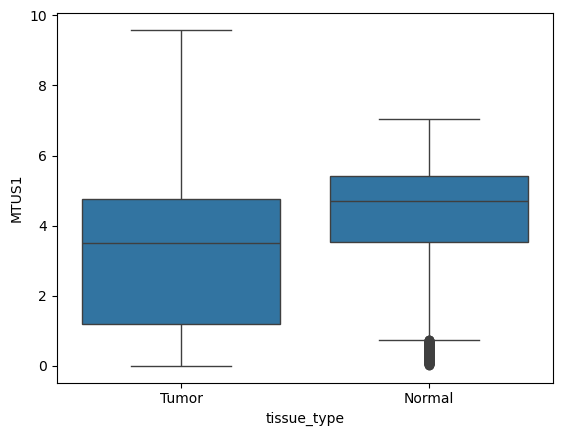

In [11]:
import seaborn as sns

sns.boxplot(x='tissue_type', y='MTUS1', data=aggs_df)

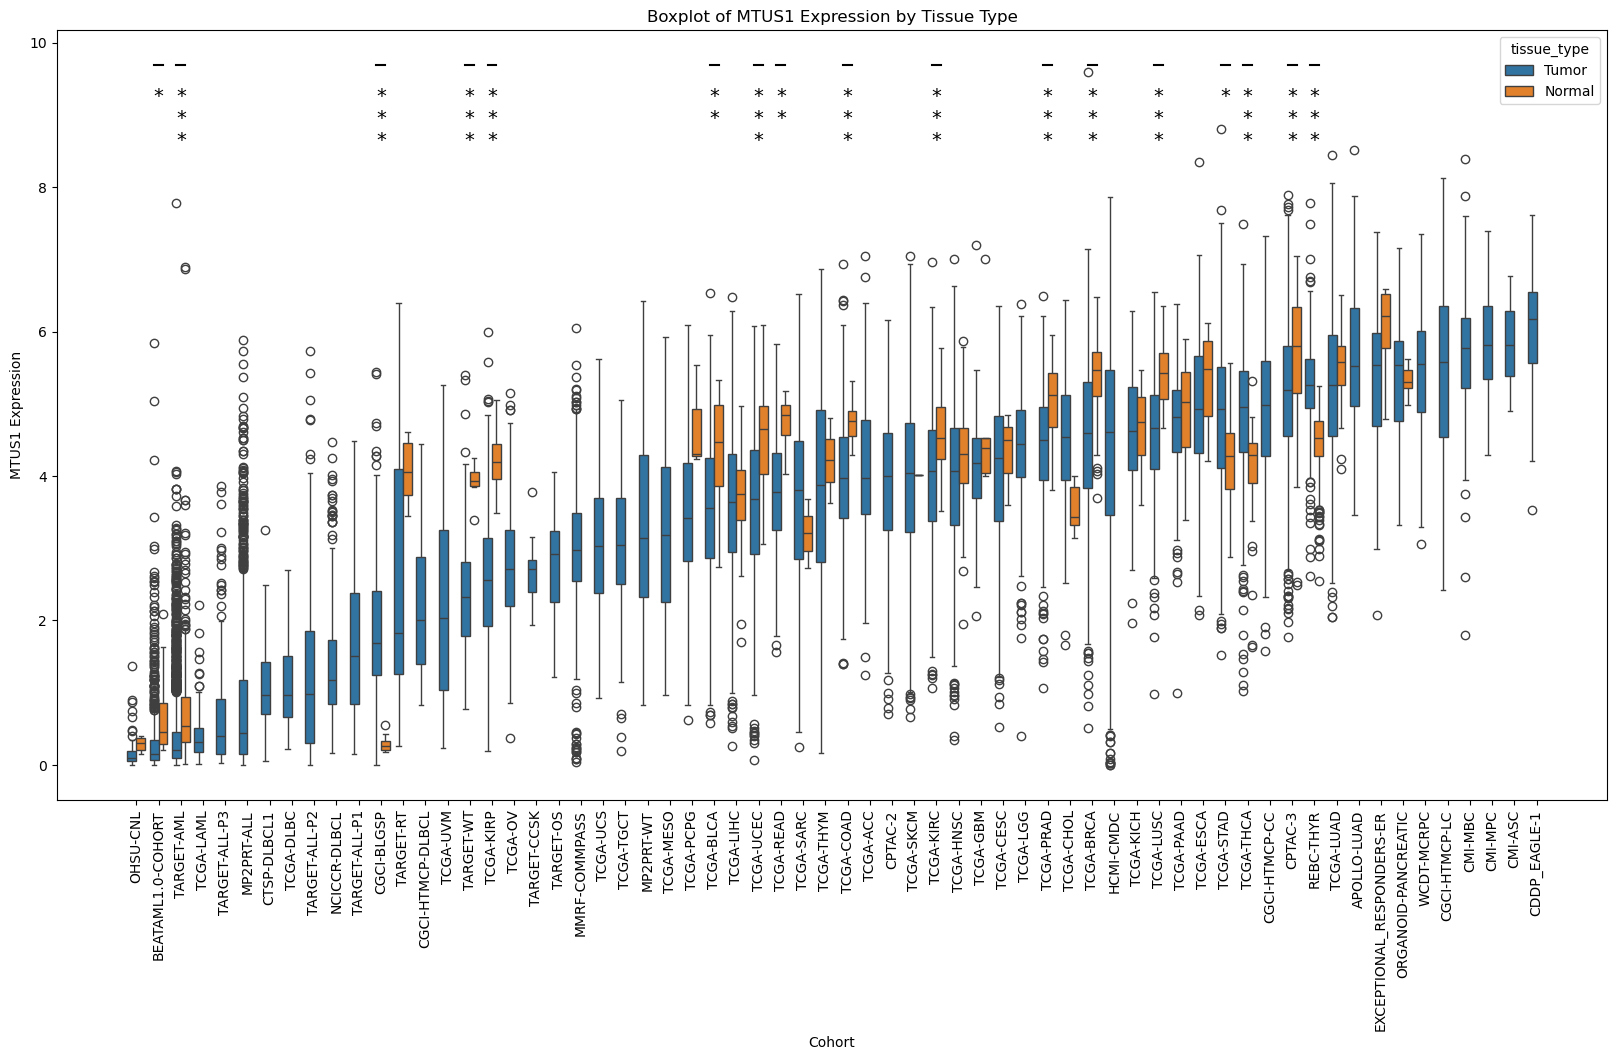

In [12]:
from scipy.stats import ttest_ind

def expression_profile_barplot(aggs_df, goi):
    diagnosis_significance = {}
    
    tumor_df = aggs_df[aggs_df['tissue_type'] == 'Tumor']
    
    cohort_order = tumor_df.groupby('cohort')[goi].median().sort_values().index
    
    plt.figure(figsize=(20, 10))
    
    sns.boxplot(x='cohort', y=goi, hue='tissue_type', data=aggs_df, order=cohort_order)
    
    for cohort in cohort_order:
        tumor_values = aggs_df[(aggs_df['cohort'] == cohort) & (aggs_df['tissue_type'] == 'Tumor')][goi]
        normal_values = aggs_df[(aggs_df['cohort'] == cohort) & (aggs_df['tissue_type'] == 'Normal')][goi]
        p_value = ttest_ind(tumor_values, normal_values)[1]
        diagnosis_significance[cohort] = p_value
        
        if p_value < 0.0001:
            significance = '*\n*\n*'
        elif p_value < 0.001:
            significance = '*\n*'
        elif p_value < 0.01:
            significance = '*'
        else:
            significance = ''  # No significance
            
        if significance:
            plt.plot([cohort_order.tolist().index(cohort) - 0.2, cohort_order.tolist().index(cohort) + 0.2], 
                     [aggs_df[goi].max() + 0.1, aggs_df[goi].max() + 0.1], 
                     lw=1.5, color='black')
            plt.text(cohort_order.tolist().index(cohort), aggs_df[goi].max() - 0.2, significance, ha='center',
                     va='top', fontsize=14)
    
    plt.xticks(rotation=90)
    plt.xlabel('Cohort')
    plt.ylabel(f'{goi} Expression')
    plt.title(f'Boxplot of {goi} Expression by Tissue Type')
    
    # Show plot
    plt.show()

expression_profile_barplot(aggs_df, goi)

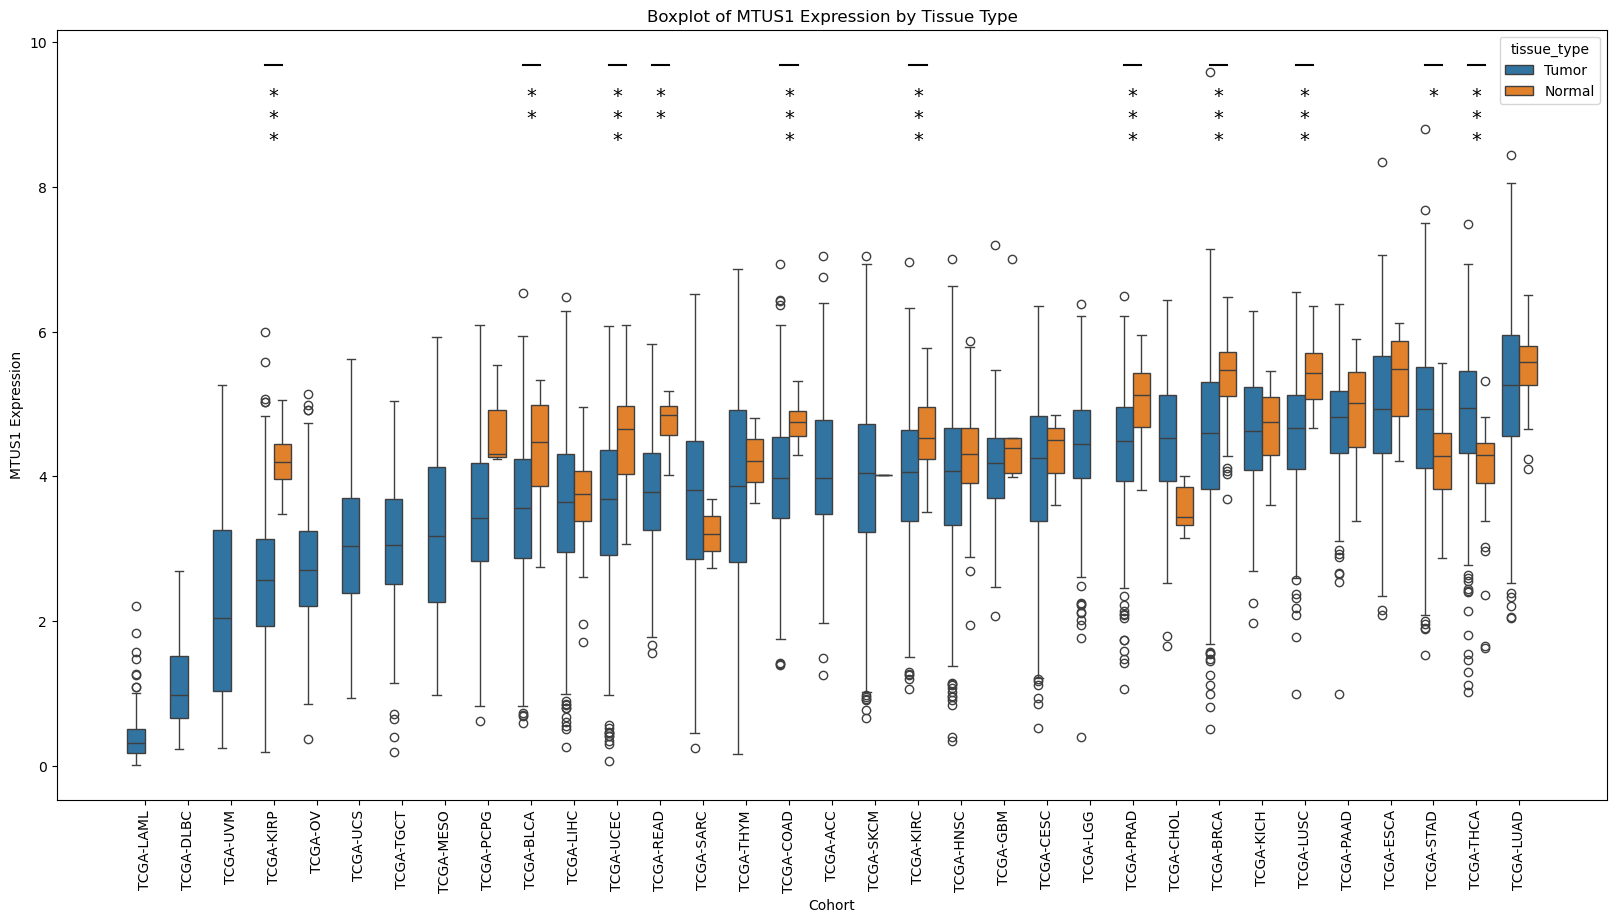

In [13]:
tcga_cohorts = aggs_df['cohort'].apply(lambda x: 'TCGA' in x)

expression_profile_barplot(aggs_df[tcga_cohorts].copy(), goi)

## BRCA analysis

In [185]:
coh = 'TCGA-BRCA'

counts_df = pd.read_csv(f'{expanded_directory}/{coh}/counts.tsv', sep='\t', index_col=0).T
qc = pd.read_csv(f'{expanded_directory}/{coh}/qc.tsv', sep='\t', index_col=0)
ann = pd.read_csv(f'{expanded_directory}/{coh}/clin_annotation.tsv', sep='\t', index_col=0)
ann.replace("'--", np.nan, inplace=True)
file_annot = pd.read_csv(f'{expanded_directory}/{coh}/file_annotation.tsv', sep='\t', index_col=0)
tpm = pd.read_csv(f'{expanded_directory}/{coh}/tpm.tsv', sep='\t', index_col=0).T
tpm = np.log2(tpm + 1)

In [187]:
metadata = file_annot[['tissue_type', 'tumor_descriptor', 'case_id']]
metadata = metadata.loc[counts_df.index]

In [188]:
metadata.shape

(1231, 3)

### DE

In [189]:
import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

In [190]:
samples_to_keep = qc['qc_passed_flag']
tpm = tpm.loc[samples_to_keep]
counts_df = counts_df.loc[samples_to_keep]
metadata = metadata.loc[samples_to_keep]

genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]

In [29]:
def de_pipeline(counts_df, metadata, design_factors):
    inference = DefaultInference(n_cpus=8)
    dds = DeseqDataSet(
        counts=counts_df,
        metadata=metadata,
        design_factors=design_factors,
        refit_cooks=True,
        inference=inference
    )

    dds.deseq2()

    stat_res = DeseqStats(dds, inference=inference)
    stat_res.summary()
    coeff = stat_res.dds.obsm['design_matrix'].columns[-1]
    stat_res.lfc_shrink(coeff=coeff)
    
    significance_dict = {True: 'significant', False: 'not significant'}
    
    stat_res.results_df['significant'] = (stat_res.results_df.padj < 0.01)  & (np.abs(stat_res.results_df.log2FoldChange) > 1.2)
    stat_res.results_df['significant'] = stat_res.results_df['significant'].apply(lambda x: significance_dict[x])
    
    mtus1 = pd.DataFrame(stat_res.results_df.loc['MTUS1']).T
    hlf = pd.DataFrame(stat_res.results_df.loc['HLF']).T
    
    plt.figure(figsize=(10, 6))
    
    sns.scatterplot(data=stat_res.results_df, x='log2FoldChange', y=-np.log10(stat_res.results_df['pvalue'] + 1e-300), hue='significant')
    
    sns.scatterplot(data=mtus1, x='log2FoldChange', y=-(mtus1['pvalue'] + 1e-300).apply(lambda x: np.log10(x)), color='red', label='MTUS1')
    
    sns.scatterplot(data=hlf, x='log2FoldChange', y=-(hlf['pvalue'] + 1e-300).apply(lambda x: np.log10(x)), color='green', label='HLF')
    
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-log10(p-value)')
    plt.title(f'Volcano Plot for {coeff.split('_')[-3:]}')
    plt.legend(title='Significant')
    plt.show()

    return stat_res.results_df

#### Tumor vs Normal

In [192]:
metadata.shape

(1222, 3)

/var/folders/pw/6k2v94gd04ldnq4v79jj6lrr0000gn/T/ipykernel_39987/1259522390.py:3: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.68 seconds.

Fitting dispersions...
... done in 4.66 seconds.

Fitting dispersion trend curve...
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 4.92 seconds.

Fitting LFCs...
... done in 9.93 seconds.

Replacing 2842 outlier genes.

Fitting dispersions...
... done in 0.76 seconds.

Fitting MAP dispersions...
... done in 0.80 seconds.

Fitting LFCs...
... done in 1.61 seconds.

Running Wald tests...
... done in 6.55 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: tissue-type Tumor vs Normal
               baseMean  log2FoldChange     lfcSE       stat        pvalue  \
gene_name                                                                    
A1BG          14.820110        0.352984  0.094452   3.737176  1.860986e-04   
A1CF           4.664129        0.096755  0.216377   0.447160  6.547599e-01   
A2M        43047.646329       -1.132724  0.098248 -11.529275  9.393168e-31   
A2ML1        635.010311        3.232437  0.267478  12.084853  1.269974e-33   
A3GALT2        2.673733       -0.339395  0.188748  -1.798134  7.215579e-02   
...                 ...             ...       ...        ...           ...   
ZYG11A       328.903851        1.519155  0.127021  11.959848  5.766772e-33   
ZYG11B      2773.159273       -0.628447  0.054710 -11.486858  1.535978e-30   
ZYX         9654.317734       -0.320554  0.068515  -4.678618  2.888155e-06   
ZZEF1       3814.934342       -0.495548  0.054607  -9.074755  1.139335e-19  

... done in 3.98 seconds.



Shrunk log2 fold change & Wald test p-value: tissue-type Tumor vs Normal
               baseMean  log2FoldChange     lfcSE       stat        pvalue  \
gene_name                                                                    
A1BG          14.820110        0.348850  0.094171   3.737176  1.860986e-04   
A1CF           4.664129        0.011157  0.211216   0.447160  6.547599e-01   
A2M        43047.646329        0.883694  0.063898 -11.529275  9.393168e-31   
A2ML1        635.010311        3.487009  0.270407  12.084853  1.269974e-33   
A3GALT2        2.673733       -0.073347  0.188097  -1.798134  7.215579e-02   
...                 ...             ...       ...        ...           ...   
ZYG11A       328.903851        1.506987  0.127387  11.959848  5.766772e-33   
ZYG11B      2773.159273       -0.600513  0.054258 -11.486858  1.535978e-30   
ZYX         9654.317734        0.089551  0.060762  -4.678618  2.888155e-06   
ZZEF1       3814.934342       -0.428523  0.053425  -9.074755  1.13933

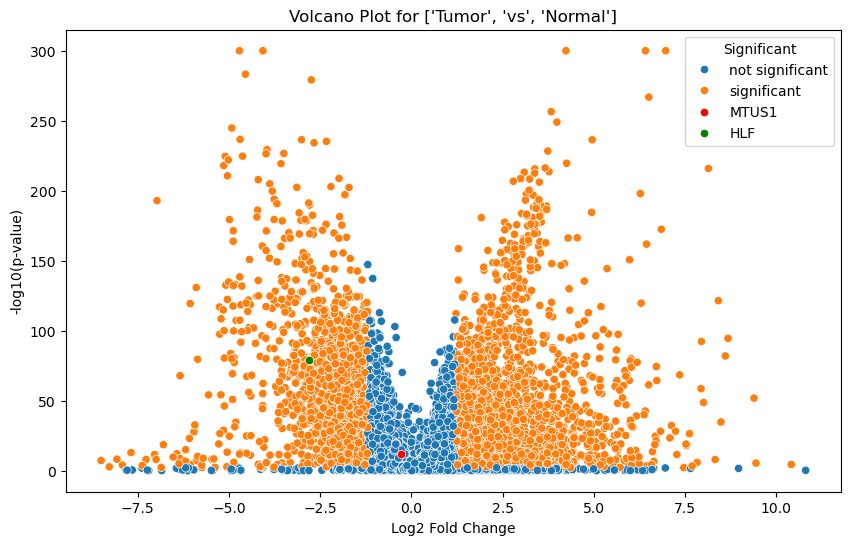

In [95]:
tumor_vs_normal_res = de_pipeline(counts_df, metadata, 'tissue_type')

#### MTUS1 expression HIGH vs LOW

In [193]:
tpm.shape

(1222, 19938)

In [194]:
def label_expression(x, gene_name, tpm):
    q25 = tpm[gene_name].quantile(0.25)
    q75 = tpm[gene_name].quantile(0.75)

    if x > q75:
        return 'HIGH'
    elif x < q25:
        return 'LOW'
    else:
        return 'MED'

metadata['MTUS1_expression'] = tpm['MTUS1'].apply(lambda x: label_expression(x, 'MTUS1', tpm))

In [195]:
 tpm['MTUS1'].apply(lambda x: label_expression(x, 'MTUS1', tpm))

0d140db1-dc0d-431d-b389-846d05bbb827     MED
800ca72f-4bd7-46d7-904b-bcda2fa3500c     MED
958813f4-8036-42f7-856d-7a69c4175adc     MED
c7646bc5-436b-4ad5-b5ae-894b2e843cda    HIGH
90e074a0-ca6d-4031-aa26-f79e5c662ba7     MED
                                        ... 
8c884351-1c8b-47ff-8bef-1a4f25f645fb    HIGH
575ef8e2-dfbc-48b3-9836-089b94498e09    HIGH
ada5cdcf-f9e0-4209-aa92-ac3b921bbdf4     LOW
18340589-696e-4f56-80c2-dc7d7428c471     MED
56e43b33-6dc7-496b-bdee-75e5fed5d502     MED
Name: MTUS1, Length: 1222, dtype: object

In [196]:
metadata['MTUS1_expression'].value_counts()

samples_to_drop = metadata['MTUS1_expression'] == 'MED'
metadata_surv = metadata.loc[~samples_to_drop]

/var/folders/pw/6k2v94gd04ldnq4v79jj6lrr0000gn/T/ipykernel_79072/1259522390.py:3: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.27 seconds.

Fitting dispersions...
... done in 2.70 seconds.

Fitting dispersion trend curve...
... done in 0.25 seconds.

Fitting MAP dispersions...
... done in 2.80 seconds.

Fitting LFCs...
... done in 3.24 seconds.

Replacing 3261 outlier genes.

Fitting dispersions...
... done in 0.48 seconds.

Fitting MAP dispersions...
... done in 0.47 seconds.

Fitting LFCs...
... done in 0.58 seconds.

Running Wald tests...
... done in 1.75 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: MTUS1-expression LOW vs HIGH
               baseMean  log2FoldChange     lfcSE       stat        pvalue  \
gene_name                                                                    
A1BG          14.751089       -0.295068  0.078085  -3.778812  1.575785e-04   
A1CF           4.352395        0.066625  0.171953   0.387459  6.984163e-01   
A2M        41110.273253       -0.328684  0.085454  -3.846320  1.199052e-04   
A2ML1        949.419002        2.304103  0.217589  10.589240  3.342964e-26   
A3GALT2        2.764490        0.521192  0.163330   3.191028  1.417674e-03   
...                 ...             ...       ...        ...           ...   
ZYG11A       341.862187        0.426534  0.103719   4.112398  3.915708e-05   
ZYG11B      2683.481151       -0.427644  0.044006  -9.717888  2.529731e-22   
ZYX         9657.832163        0.309112  0.056573   5.463969  4.656036e-08   
ZZEF1       3766.912424       -0.570447  0.045135 -12.638619  1.293043e-36 

... done in 2.27 seconds.



Shrunk log2 fold change & Wald test p-value: MTUS1-expression LOW vs HIGH
               baseMean  log2FoldChange     lfcSE       stat        pvalue  \
gene_name                                                                    
A1BG          14.751089       -0.289671  0.078057  -3.778812  1.575785e-04   
A1CF           4.352395        0.203725  0.165779   0.387459  6.984163e-01   
A2M        41110.273253        0.947227  0.091376  -3.846320  1.199052e-04   
A2ML1        949.419002        1.308276  0.218614  10.589240  3.342964e-26   
A3GALT2        2.764490       -0.316307  0.158646   3.191028  1.417674e-03   
...                 ...             ...       ...        ...           ...   
ZYG11A       341.862187        0.406594  0.103381   4.112398  3.915708e-05   
ZYG11B      2683.481151       -0.414962  0.044032  -9.717888  2.529731e-22   
ZYX         9657.832163        0.338858  0.056478   5.463969  4.656036e-08   
ZZEF1       3766.912424       -0.544115  0.045247 -12.638619  1.2930

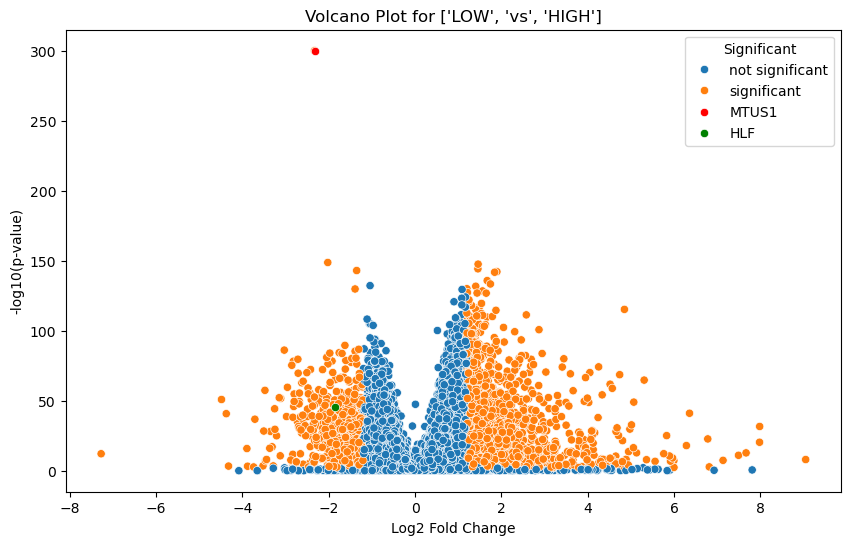

In [197]:
mtus1_de_res = de_pipeline(counts_df.loc[metadata_surv.index], metadata_surv, 'MTUS1_expression')

#### Survival

In [198]:
surv_cols = ['case_id', 'days_to_death', 'days_to_last_follow_up', 'vital_status', 'treatment_or_therapy']
ann_surv = ann[surv_cols].copy().set_index('case_id', drop=True).drop_duplicates()


ann_surv['deceased'] = ann_surv['vital_status'].apply(lambda x: False if x == 'Alive' else True)
ann_surv['days_to_death'] = ann_surv['days_to_death'].astype(float).apply(lambda x: np.max([x, 0]))
ann_surv['days_to_last_follow_up'] = ann_surv['days_to_last_follow_up'].astype(float).apply(lambda x: np.max([x, 0]))

ann_surv['OS'] = ann_surv.apply(lambda row: row['days_to_last_follow_up'] if row['vital_status'] == 'Alive' else row['days_to_death'], axis=1).astype(float)
ann_surv['OS_FLAG'] = ann_surv['deceased']

In [199]:
ann_surv = ann_surv.dropna(subset=['OS', 'OS_FLAG'])
ann_surv.shape

(1229, 7)

In [200]:
def quantile_label_trio(x, df, col):
    ql = df[col].quantile(0.3)
    qh = df[col].quantile(0.7)
    
    if x > qh:
        return 'HIGH'
    elif x < ql:
        return 'LOW'
    else:
        return 'MED'

ann_surv['OS_quant'] = ann_surv['OS'].apply(lambda x: quantile_label_trio(x, ann_surv, 'OS'))
ann_surv['OS_quant']

case_id
001cef41-ff86-4d3f-a140-a647ac4b10a1     LOW
001cef41-ff86-4d3f-a140-a647ac4b10a1     LOW
0045349c-69d9-4306-a403-c9c1fa836644     LOW
00807dae-9f4a-4fd1-aac2-82eb11bf2afb    HIGH
00807dae-9f4a-4fd1-aac2-82eb11bf2afb    HIGH
                                        ... 
fcef8cb5-fb2c-4bfb-82cd-6b9f3145182c     LOW
fd0b1b8b-1a76-480a-b61c-d176e4e02c6b    HIGH
fe15c48b-116d-461e-9b40-68514730fd18    HIGH
fe7f74b8-20f4-4471-91dc-4cca8c68e5c0     MED
fe7f74b8-20f4-4471-91dc-4cca8c68e5c0     MED
Name: OS_quant, Length: 1229, dtype: object

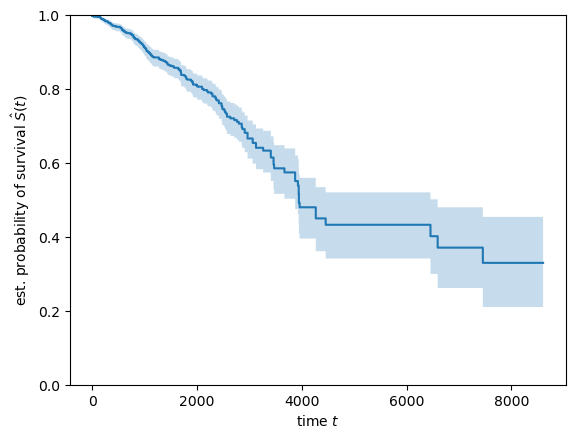

In [201]:
from sksurv.nonparametric import kaplan_meier_estimator

def km_plot(ann_surv):

    time, survival_prob, conf_int = kaplan_meier_estimator(
        ann_surv["OS_FLAG"], ann_surv["OS"], conf_type="log-log"
    )
    
    plt.step(time, survival_prob, where="post")
    plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    plt.ylim(0, 1)
    plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$");

km_plot(ann_surv)

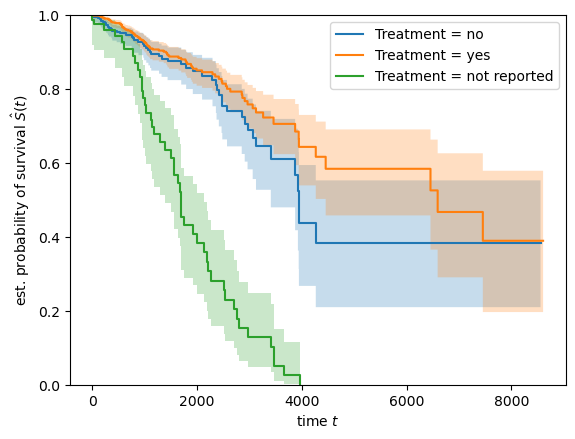

In [202]:
for type in ann_surv['treatment_or_therapy'].unique():
    mask_treat = ann_surv["treatment_or_therapy"] == type
    time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
        ann_surv["OS_FLAG"][mask_treat],
        ann_surv["OS"][mask_treat],
        conf_type="log-log",
    )

    plt.step(time_treatment, survival_prob_treatment, where="post", label=f"Treatment = {type}")
    plt.fill_between(time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best");

In [203]:
matched_metadata_ids = metadata['case_id'].isin(ann_surv.index).copy()
ann_surv_expr = ann_surv.loc[metadata[matched_metadata_ids]['case_id']].copy()

metadata['MTUS1_expression'] = tpm['MTUS1']
metadata['MTUS1_expression_quant'] = tpm['MTUS1'].apply(lambda x: label_expression(x, 'MTUS1', tpm))
ann_surv_expr['MTUS1_expression_quant'] = metadata.groupby('case_id')['MTUS1_expression'].max().apply(lambda x: label_expression(x, 'MTUS1', tpm))

metadata['HLF_expression'] = tpm['HLF']
metadata['HLF_expression_quant'] = tpm['HLF'].apply(lambda x: label_expression(x, 'HLF', tpm))
ann_surv_expr['HLF_expression_quant'] = metadata.groupby('case_id')['HLF_expression'].max().apply(lambda x: label_expression(x, 'HLF', tpm))

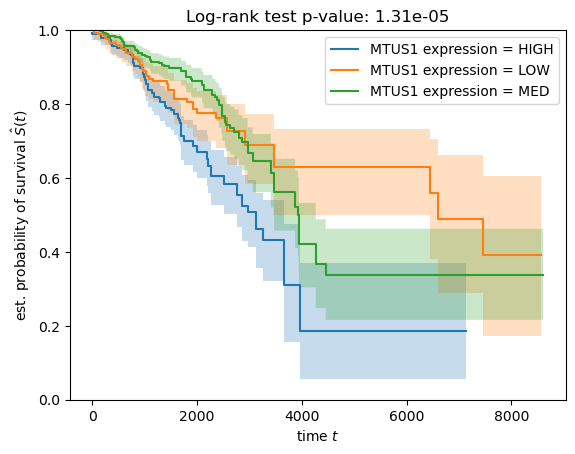

In [204]:
from sksurv.compare import compare_survival

def logrank_km(ann_surv, group_indicator, title):

    y = np.array(
        list(zip(ann_surv["OS_FLAG"], ann_surv["OS"])), 
        dtype=[('status', bool), ('time', float)]
    )
    
    for type in np.unique(group_indicator):
        mask_treat = group_indicator == type
        time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
            ann_surv["OS_FLAG"][mask_treat],
            ann_surv["OS"][mask_treat],
            conf_type="log-log",
        )
    
        plt.step(time_treatment, survival_prob_treatment, where="post", label=f"{title} = {type}")
        plt.fill_between(time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post")
    
    chisq, p_value = compare_survival(y, group_indicator, return_stats=False)
    plt.title(f"Log-rank test p-value: {p_value:.2e}", fontsize=12)
    
    plt.ylim(0, 1)
    plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.show()

logrank_km(ann_surv_expr, ann_surv_expr['MTUS1_expression_quant'], title='MTUS1 expression')

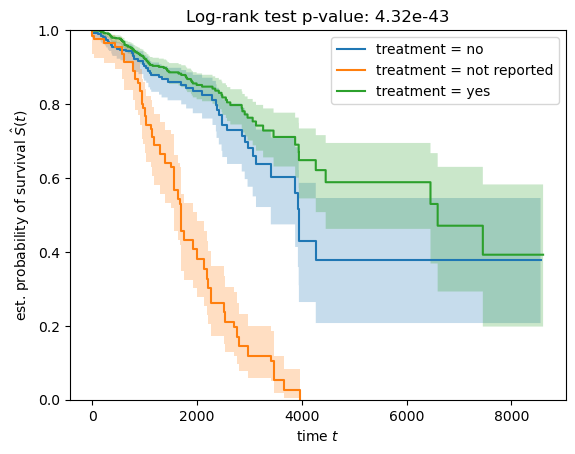

In [205]:
logrank_km(ann_surv_expr, ann_surv_expr['treatment_or_therapy'],  title='treatment')

In [206]:
metadata['case_id'] = file_annot['case_id']

In [207]:
case_id2os = ann_surv['OS'].to_dict()
case_id2os_quant = ann_surv['OS_quant'].to_dict()
case_id2os_flag = ann_surv['OS_FLAG'].to_dict()
case_id2status = ann_surv['deceased'].to_dict()

In [208]:
metadata['OS'] = metadata['case_id'].map(case_id2os)
metadata['OS_quant'] = metadata['case_id'].map(case_id2os_quant)
metadata['OS_FLAG'] = metadata['case_id'].map(case_id2os_flag)
metadata['deceased'] = metadata['case_id'].map(case_id2status)

In [209]:
metadata['OS_quant'].unique()

array(['MED', nan, 'HIGH', 'LOW'], dtype=object)

In [210]:
metadata_surv = metadata.dropna(subset=['OS_quant', 'OS_FLAG'])
metadata_surv = metadata_surv[metadata_surv['OS_quant'] != 'MED']

In [211]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts_df.loc[metadata_surv.index],
    metadata=metadata_surv,
    design_factors="OS_quant",
    refit_cooks=True,
    inference=inference,
    # n_cpus=8, # n_cpus can be specified here or in the inference object
)

dds.deseq2()

stat_res = DeseqStats(dds, inference=inference)
stat_res.summary()
stat_res.lfc_shrink(coeff="OS-quant_LOW_vs_HIGH")

stat_res.results_df['significant'] = (stat_res.results_df.padj < 0.01)  & (np.abs(stat_res.results_df.log2FoldChange) > 1.2)
significance_dict = {True: 'significant', False: 'not significant'}

stat_res.results_df['significant'] = stat_res.results_df['significant'].apply(lambda x: significance_dict[x])

mtus1 = pd.DataFrame(stat_res.results_df.loc['MTUS1']).T
hlf = pd.DataFrame(stat_res.results_df.loc['HLF']).T

plt.figure(figsize=(10, 6))

sns.scatterplot(data=stat_res.results_df, x='log2FoldChange', y=-np.log10(stat_res.results_df['pvalue'] + 1e-300), hue='significant')

sns.scatterplot(data=mtus1, x='log2FoldChange', y=-(mtus1['pvalue'] + 1e-300).apply(lambda x: np.log10(x)), color='red', label='MTUS1')

sns.scatterplot(data=hlf, x='log2FoldChange', y=-(hlf['pvalue'] + 1e-300).apply(lambda x: np.log10(x)), color='green', label='HLF')

plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot for survival in BRCA')
plt.legend(title='Significant')
plt.show()

/var/folders/pw/6k2v94gd04ldnq4v79jj6lrr0000gn/T/ipykernel_79072/1518585905.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.29 seconds.

Fitting dispersions...


KeyboardInterrupt: 

### TNBC

To compare mRNA expression with IHC results and eliminate potential false negative and include false positives, we approximated the empirical distributions ESR1, PGR and ERRBB2 mRNA expression from each dataset individually using a two-component Gaussian mixture (R optim package). The following probe sets were used for each of the datasets: GSE41998, GSE25066 and GSE32646; ESR1 (205225_at), PGR (PR208305_at) and ERBB2 (216836_s_at), GSE22226 (GPL4133); ESR1_18336, PGR_2744, and ERBB2_43498, GSE22226 (GPL4133); ESR1_26884, PGR_6923, and ERBB2_37893, GSE22358; ESR1_26884, PGR_15163, and ERBB2_38777. Given the estimated distributions, the posterior probability of negative expression status of ER, PR and HER2 were determined and samples negative for expression of each of these markers identified

<Axes: xlabel='ESR1', ylabel='PGR'>

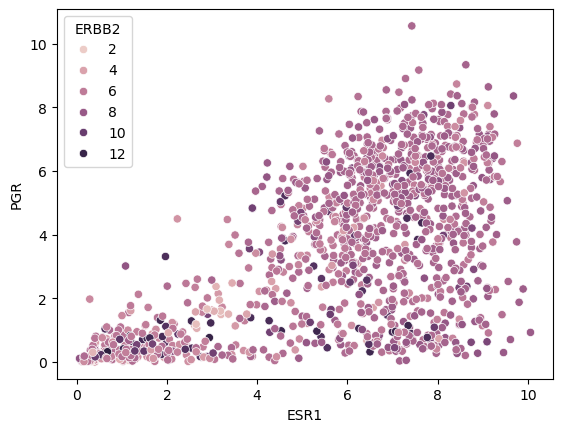

In [212]:
sns.scatterplot(data=tpm, x='ESR1', y='PGR', hue='ERBB2')

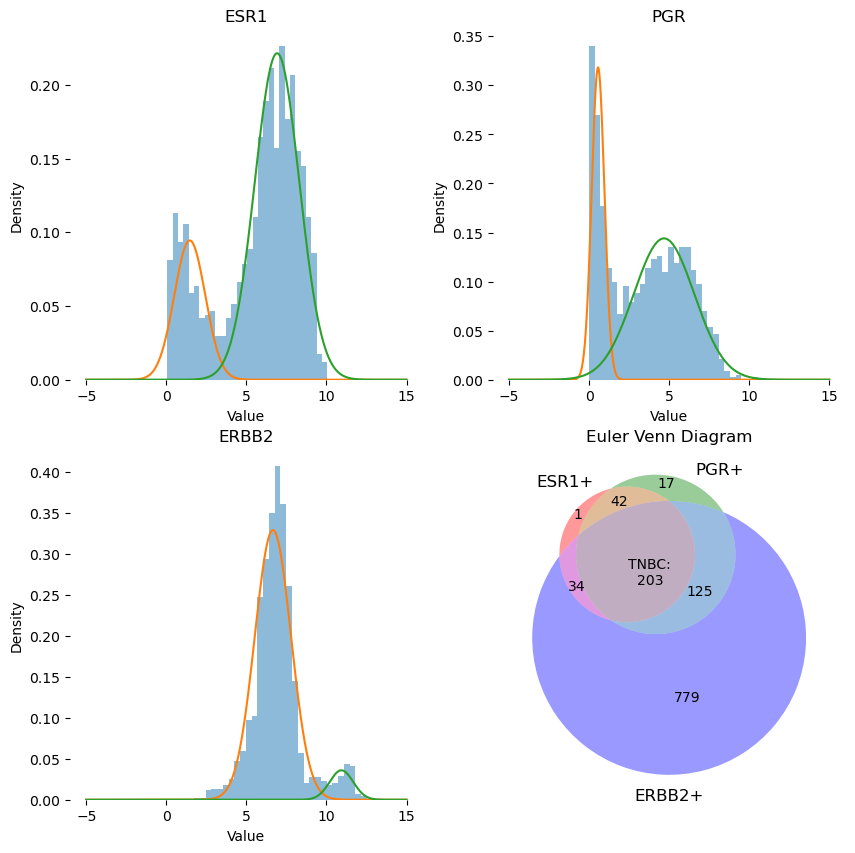

In [213]:
from sklearn.mixture import GaussianMixture
from matplotlib_venn import venn3

results = dict()

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()

for i, gene in enumerate(['ESR1', 'PGR', 'ERBB2']):
    gmm = GaussianMixture(n_components=2)
    gmm.fit(tpm[gene].values.reshape(-1, 1))

    labels = gmm.predict(tpm[gene].values.reshape(-1, 1))

    subset0_mean = tpm[gene][labels == 0].mean()
    subset1_mean = tpm[gene][labels == 1].mean()

    if subset1_mean > subset0_mean:
        labels_high = labels == 1
    else:
        labels_high = labels == 0
    
    fraction_component1 = np.mean(labels_high == False)
    fraction_component2 = np.mean(labels_high == True)
    results[gene] = labels_high

    means = gmm.means_.flatten()
    covariances = gmm.covariances_.flatten()
    
    sorted_ids = np.argsort(means)
    means = means[sorted_ids]
    covariances = covariances[sorted_ids]

    ax[i].hist(tpm[gene].values.reshape(-1, 1), bins=30, density=True, alpha=0.5)
    x = np.linspace(-5, 15, 1000).reshape(-1, 1)
    ax[i].plot(x, fraction_component1 * np.exp(-(x - means[0])**2 / (2 * covariances[0])) / np.sqrt(2 * np.pi * covariances[0]), label='Component 1')
    ax[i].plot(x, fraction_component2 * np.exp(-(x - means[1])**2 / (2 * covariances[1])) / np.sqrt(2 * np.pi * covariances[1]), label='Component 2')
    ax[i].set_xlabel('Value')
    ax[i].set_ylabel('Density')
    ax[i].set_title(gene)
    ax[i].spines[['top', 'right', 'bottom', 'left']].set_visible(False)

data = results

sets = {
    'ESR1': set(tpm.index[~data['ESR1'].astype(bool)]),
    'PGR': set(tpm.index[~data['PGR'].astype(bool)]),
    'ERBB2': set(tpm.index[~data['ERBB2'].astype(bool)])
}

venn = venn3(subsets=[sets['ESR1'], sets['PGR'], sets['ERBB2']],
             set_labels=('ESR1+', 'PGR+', 'ERBB2+'), ax=ax[3])

tnbc_size = venn.get_label_by_id('111')._text 
venn.get_label_by_id('111').set_text(f'TNBC:\n{tnbc_size}')

ax[3].set_title("Euler Venn Diagram")

plt.show()

In [214]:
tnbc_mask = (~results['ESR1']) & (~results['PGR']) & (~results['ERBB2'])
tnbc_mask.sum()

203

In [215]:
tnbc_ids = tpm[tnbc_mask].index
tnbc_ids

Index(['0d140db1-dc0d-431d-b389-846d05bbb827',
       'd141392c-757b-44f5-b531-0bcc136d8b17',
       '7860a938-e43a-4c3a-83b4-6578cea95df8',
       '4b8ef410-8612-4c64-839f-47770deba446',
       '0ed77a2e-a2c9-4557-8ba3-2c8bade9b792',
       '50c7c034-fccb-4eb1-b8db-e0a5d9e50172',
       '4b445a8f-b60b-44c3-b501-de93010172f7',
       '57044315-cc7f-4677-90fa-2e959740bd9c',
       '148fc636-0b7b-4f10-b513-45edcf71a79e',
       'e3cfb618-5ed2-4841-b7c1-a9f049ac8f9d',
       ...
       'c4ceaaf8-4803-45d7-9937-42d25db60148',
       'cbfb8ffe-ae83-4a16-aaa6-f21ea893cb8d',
       'ea5c9d47-1803-4bd5-88da-352e172bc45d',
       '5755f322-5df5-4b88-9c79-640167775c12',
       'd1237195-a00b-4c52-86b3-4627c42eb14c',
       'bbd09e9b-84ba-458f-a595-b03069b843dd',
       'e94299a9-67bc-4c30-963c-1476fbb7d5ff',
       '3f44f7ab-7299-4b8e-b2b9-16ed5291e727',
       '7f1cbb4f-aecf-42be-91cc-fb35d03447df',
       'ada5cdcf-f9e0-4209-aa92-ac3b921bbdf4'],
      dtype='object', length=203)

In [216]:
tnbc_subset = tpm[tnbc_mask].copy()

In [217]:
metadata_tnbc = metadata.loc[tpm.index[tnbc_mask]]

In [218]:
ann[ann['case_id'].isin(metadata_tnbc['case_id'])].groupby('case_id')['days_to_birth'].std().max()

0.0

In [219]:
surv_cols = ['case_id', 'days_to_death', 'days_to_last_follow_up', 'vital_status', 'treatment_or_therapy']
ann_surv = ann[surv_cols].copy().set_index('case_id', drop=True)

ann_surv['deceased'] = ann_surv['vital_status'].apply(lambda x: False if x == 'Alive' else True)
ann_surv['days_to_death'] = ann_surv['days_to_death'].astype(float).apply(lambda x: np.max([x, 0]))
ann_surv['days_to_last_follow_up'] = ann_surv['days_to_last_follow_up'].astype(float).apply(lambda x: np.max([x, 0]))

ann_surv['OS'] = ann_surv.apply(lambda row: row['days_to_last_follow_up'] if row['vital_status'] == 'Alive' else row['days_to_death'], axis=1).astype(float)
ann_surv['OS_FLAG'] = ann_surv['deceased']

In [220]:
def quantile_label_trio(x, df, col):
    ql = df[col].quantile(0.3)
    qh = df[col].quantile(0.7)
    
    if x > qh:
        return 'HIGH'
    elif x < ql:
        return 'LOW'
    else:
        return 'MED'

def quantile_label_duo(x, df, col):
    qm = df[col].quantile(0.5)
    
    if x > qm:
        return 'HIGH'
    else:
        return 'LOW'

metadata_tnbc['OS_quant'] = metadata_tnbc['OS'].apply(lambda x: quantile_label_duo(x, metadata_tnbc, 'OS'))
metadata_tnbc['OS_quant']

0d140db1-dc0d-431d-b389-846d05bbb827    HIGH
d141392c-757b-44f5-b531-0bcc136d8b17     LOW
7860a938-e43a-4c3a-83b4-6578cea95df8     LOW
4b8ef410-8612-4c64-839f-47770deba446     LOW
0ed77a2e-a2c9-4557-8ba3-2c8bade9b792    HIGH
                                        ... 
bbd09e9b-84ba-458f-a595-b03069b843dd     LOW
e94299a9-67bc-4c30-963c-1476fbb7d5ff     LOW
3f44f7ab-7299-4b8e-b2b9-16ed5291e727     LOW
7f1cbb4f-aecf-42be-91cc-fb35d03447df    HIGH
ada5cdcf-f9e0-4209-aa92-ac3b921bbdf4     LOW
Name: OS_quant, Length: 203, dtype: object

In [221]:
metadata_tnbc['OS_quant'].value_counts()

OS_quant
LOW     116
HIGH     87
Name: count, dtype: int64

/var/folders/pw/6k2v94gd04ldnq4v79jj6lrr0000gn/T/ipykernel_79072/642444332.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.09 seconds.

Fitting dispersions...
... done in 1.90 seconds.

Fitting dispersion trend curve...
... done in 0.21 seconds.

Fitting MAP dispersions...
... done in 1.95 seconds.

Fitting LFCs...
... done in 1.23 seconds.

Replacing 3615 outlier genes.

Fitting dispersions...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 0.34 seconds.

Fitting LFCs...
... done in 0.25 seconds.

Running Wald tests...
... done in 0.55 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: OS-quant LOW vs HIGH
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_name                                                               
A1BG          10.000430        0.099858  0.150089  0.665322  0.505845   
A1CF           5.135572        0.049737  0.342872  0.145061  0.884663   
A2M        55543.013965       -0.578414  0.198318 -2.916605  0.003539   
A2ML1       3387.496318       -0.310496  0.310866 -0.998810  0.317887   
A3GALT2        4.600523        0.066804  0.264623  0.252451  0.800693   
...                 ...             ...       ...       ...       ...   
ZYG11A       495.157636       -0.209338  0.194971 -1.073684  0.282964   
ZYG11B      2727.448660       -0.032757  0.092377 -0.354604  0.722886   
ZYX        11460.215461        0.076096  0.106800  0.712509  0.476150   
ZZEF1       3186.385631        0.141776  0.087911  1.612726  0.106804   
ZZZ3        3153.690359       -0.082434  0.087932 -0.937464  0.34

... done in 2.07 seconds.



Shrunk log2 fold change & Wald test p-value: OS-quant LOW vs HIGH
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_name                                                               
A1BG          10.000430        0.015637  0.085649  0.665322  0.505845   
A1CF           5.135572        0.001656  0.095293  0.145061  0.884663   
A2M        55543.013965        1.178970  0.191462 -2.916605  0.003539   
A2ML1       3387.496318       -0.019538  0.094407 -0.998810  0.317887   
A3GALT2        4.600523        0.908398  0.271591  0.252451  0.800693   
...                 ...             ...       ...       ...       ...   
ZYG11A       495.157636       -0.023315  0.091737 -1.073684  0.282964   
ZYG11B      2727.448660        0.121113  0.096605 -0.354604  0.722886   
ZYX        11460.215461        0.192342  0.115768  0.712509  0.476150   
ZZEF1       3186.385631        0.119899  0.091479  1.612726  0.106804   
ZZZ3        3153.690359       -0.055811  0.077960 -0.93746

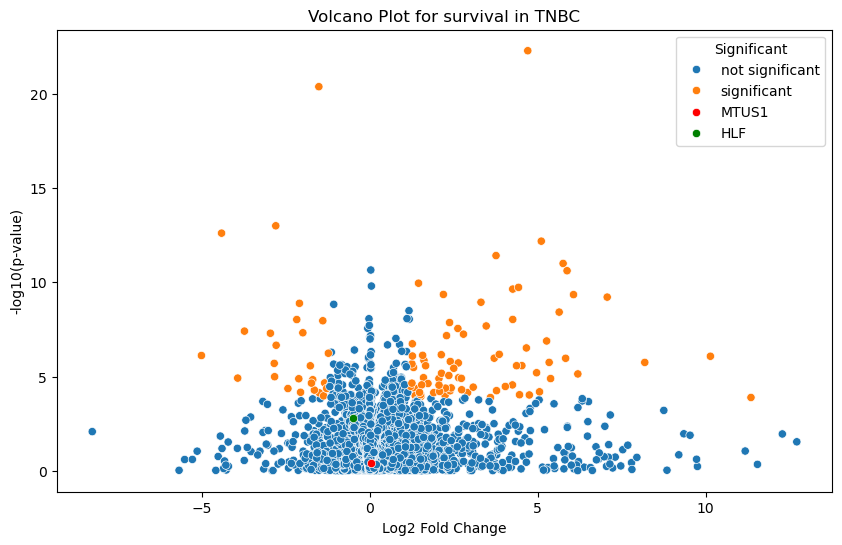

In [222]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts_df.loc[metadata_tnbc.index],
    metadata=metadata_tnbc,
    design_factors="OS_quant",
    refit_cooks=True,
    inference=inference,
    # n_cpus=8, # n_cpus can be specified here or in the inference object
)

dds.deseq2()

stat_res = DeseqStats(dds, inference=inference)
stat_res.summary()
stat_res.lfc_shrink(coeff="OS-quant_LOW_vs_HIGH")

stat_res.results_df['significant'] = (stat_res.results_df.padj < 0.01) & (np.abs(stat_res.results_df.log2FoldChange) > 1.2)
significance_dict = {True: 'significant', False: 'not significant'}

stat_res.results_df['significant'] = stat_res.results_df['significant'].apply(lambda x: significance_dict[x])

mtus1 = pd.DataFrame(stat_res.results_df.loc['MTUS1']).T
hlf = pd.DataFrame(stat_res.results_df.loc['HLF']).T

plt.figure(figsize=(10, 6))

sns.scatterplot(data=stat_res.results_df, x='log2FoldChange', y=-np.log10(stat_res.results_df['pvalue'] + 1e-300), hue='significant')

sns.scatterplot(data=mtus1, x='log2FoldChange', y=-(mtus1['pvalue'] + 1e-300).apply(lambda x: np.log10(x)), color='red', label='MTUS1')

sns.scatterplot(data=hlf, x='log2FoldChange', y=-(hlf['pvalue'] + 1e-300).apply(lambda x: np.log10(x)), color='green', label='HLF')

plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot for survival in TNBC')
plt.legend(title='Significant')
plt.show()

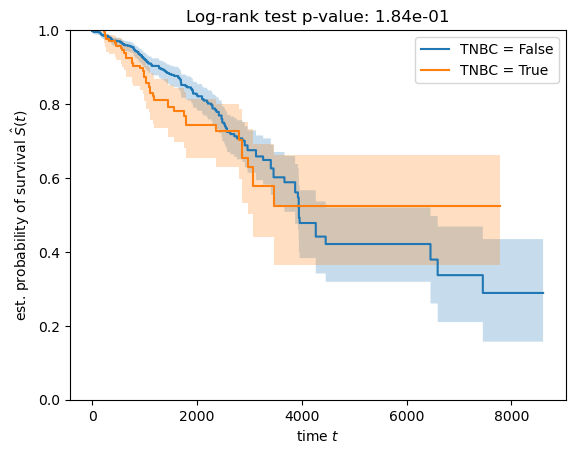

In [223]:
logrank_km(ann_surv_expr.drop_duplicates(), ann_surv_expr.drop_duplicates().index.isin(file_annot.loc[tnbc_ids].case_id), title='TNBC')

## Transcription factor exploration

In [40]:
import decoupler as dc

In [41]:
net = dc.get_collectri(organism='human', split_complexes=False)
net

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [42]:
(net['source'] == 'HLF').value_counts()

source
False    43160
True        18
Name: count, dtype: int64

In [43]:
hlf_cistrome = net[net['source'] == 'HLF']
hlf_cistrome

,source,target,weight,PMID
94,HLF,JTB,1,10073576
95,HLF,F8,1,10073576
273,HLF,EPO,1,10202154;9113979
4229,HLF,HLA-E,1,11952136
9829,HLF,ABCB1,1,16206189;18773899
16695,HLF,FGF2,1,19526458
17357,HLF,BIRC5,1,19887369
17832,HLF,CD33,1,20147975
18483,HLF,LMO2,1,12609830;20519628
19460,HLF,TSHB,1,21129973


In [44]:
net[net['target'] == 'HLF']

,source,target,weight,PMID
28019,BMAL1,HLF,1,9704006


In [45]:
tpm

gene_name,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0d140db1-dc0d-431d-b389-846d05bbb827,0.285816,0.000000,6.271851,2.425352,0.324119,4.411047,0.081203,4.595062,4.850154,2.306671,...,4.238825,7.613802,2.468844,3.608951,4.273486,2.685918,5.003701,8.093410,4.100221,5.349606
800ca72f-4bd7-46d7-904b-bcda2fa3500c,0.402395,0.062951,8.246508,0.484808,0.407081,3.798071,0.075327,5.156611,3.660655,0.159371,...,4.995299,7.253977,2.276646,3.701671,4.849369,3.737838,4.377082,7.284676,3.782262,4.655100
958813f4-8036-42f7-856d-7a69c4175adc,0.030830,0.000000,9.495995,0.269751,0.117163,4.131919,0.548042,3.994462,3.967233,4.462792,...,1.963067,2.162468,2.374900,2.999315,3.172712,0.232784,4.739902,6.433831,3.731748,3.731433
c7646bc5-436b-4ad5-b5ae-894b2e843cda,0.083792,0.000000,9.054353,0.137766,0.000000,4.456333,0.047678,4.635220,3.398501,0.000000,...,3.818820,6.229069,2.831654,4.031704,3.962725,3.264386,4.773031,7.085141,3.343465,4.507592
90e074a0-ca6d-4031-aa26-f79e5c662ba7,0.252537,0.007626,8.712741,0.218967,0.000000,3.677937,0.080385,4.984968,4.470153,0.129217,...,3.254881,6.005898,2.662433,4.254103,3.699863,2.071969,4.657674,7.181928,4.560574,4.530133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8c884351-1c8b-47ff-8bef-1a4f25f645fb,0.595886,0.048376,8.105173,0.000000,0.000000,5.508717,0.402613,5.090396,4.292760,0.433921,...,3.843471,5.967270,3.165928,4.435435,4.956308,1.636265,4.653226,7.305500,3.876242,3.911490
575ef8e2-dfbc-48b3-9836-089b94498e09,0.101516,0.007339,8.166906,2.106348,0.307312,2.389209,0.038858,4.782110,4.000694,0.000000,...,4.717857,6.587593,2.246134,3.552279,4.094253,3.052433,4.546666,6.942568,3.944971,3.853517
ada5cdcf-f9e0-4209-aa92-ac3b921bbdf4,0.217479,0.050328,8.122973,4.153076,0.509949,2.526344,0.024887,3.831928,2.715762,0.079975,...,3.623446,5.001046,2.168449,3.439118,3.947161,1.584963,4.311525,7.079741,3.671950,4.669140
18340589-696e-4f56-80c2-dc7d7428c471,0.216982,0.000000,8.986068,0.410233,0.212383,5.206893,0.241840,5.183078,2.998575,0.000000,...,3.472982,3.964537,2.866671,3.999396,4.265737,1.628447,4.560483,8.040960,4.071059,4.505281


In [46]:
hlf_cistrome.target.values

array(['JTB', 'F8', 'EPO', 'HLA-E', 'ABCB1', 'FGF2', 'BIRC5', 'CD33',
       'LMO2', 'TSHB', 'PER2', 'TNF', 'CYP7A1', 'VEGFA', 'DBP', 'RUNX1',
       'TLE6', 'TLE2'], dtype=object)

In [23]:
import sys; print(sys.version)
import platform; print(platform.python_implementation()); print(platform.platform())
import gseapy; print(gseapy.__version__)

3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:35:20) [Clang 16.0.6 ]
CPython
macOS-14.4-arm64-arm-64bit
1.1.2


In [176]:
genesets = {'hlf_cistrome': list(hlf_cistrome.target.values)}

In [177]:
metadata.head()

,tissue_type,tumor_descriptor,case_id,MTUS1_expression,MTUS1_expression_quant,HLF_expression,HLF_expression_quant,OS,OS_quant,OS_FLAG,deceased
0d140db1-dc0d-431d-b389-846d05bbb827,Tumor,Primary,408cb583-6dc3-4698-8bd2-e284042bd5ef,5.047198,MED,2.176801,MED,1417.0,MED,False,False
800ca72f-4bd7-46d7-904b-bcda2fa3500c,Tumor,Primary,ff0f875f-113a-4c0f-8c0a-4259cd496e6d,4.102675,MED,1.063365,MED,NaN,NaN,NaN,NaN
958813f4-8036-42f7-856d-7a69c4175adc,Normal,Not Applicable,408cb583-6dc3-4698-8bd2-e284042bd5ef,4.778813,MED,5.187463,HIGH,1417.0,MED,False,False
c7646bc5-436b-4ad5-b5ae-894b2e843cda,Tumor,Primary,bef7b135-a727-45e8-850a-cc4cd56c49aa,5.428250,HIGH,4.800755,HIGH,1887.0,HIGH,False,False
90e074a0-ca6d-4031-aa26-f79e5c662ba7,Tumor,Primary,8332806e-f547-4aae-89af-6d5bec831fd2,5.065413,MED,0.468635,LOW,76.0,LOW,False,False


In [224]:
tpm.shape

(1222, 19938)

In [225]:
metadata.shape

(1222, 11)

In [228]:
(metadata.index == tpm.index).sum()

1222

In [229]:
result = gseapy.gsea(data=tpm.T, gene_sets=genesets, cls=metadata['tissue_type'])

In [230]:
print(result.res2d)

   Name          Term        ES       NES NOM p-val FDR q-val FWER p-val  \
0  gsea  hlf_cistrome -0.549531 -1.634976  0.019608  0.019608   0.019608   

  Tag %  Gene %                                      Lead_genes  
0  9/18  11.37%  FGF2;F8;LMO2;ABCB1;CYP7A1;HLA-E;PER2;TSHB;TLE2  


In [231]:
result.res2d.head(5)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,hlf_cistrome,-0.549531,-1.634976,0.019608,0.019608,0.019608,9/18,11.37%,FGF2;F8;LMO2;ABCB1;CYP7A1;HLA-E;PER2;TSHB;TLE2


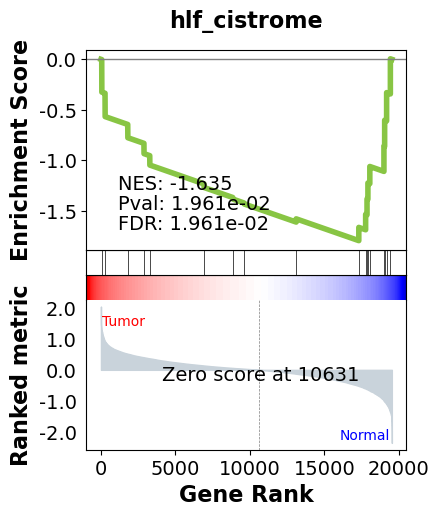

In [233]:
terms = result.res2d.Term
axs = result.plot(terms=terms[0]) # v1.0.5
# to make more control on the plot, use
# from gseapy import gseaplot
# gseaplot(rank_metric=pre_res.ranking, term=terms[0], ofname='your.plot.pdf', **pre_res.results[terms[0]])

In [242]:
tnbc_dict = {True: 'TNBC', False: 'Non TNBC'}
tnbc_names = np.vectorize(tnbc_dict.get)(tnbc_mask)
tnbc_names

array(['TNBC', 'Non TNBC', 'Non TNBC', ..., 'TNBC', 'Non TNBC',
       'Non TNBC'], dtype='<U8')

In [243]:
result = gseapy.gsea(data=tpm.T, gene_sets=genesets, cls=tnbc_names)

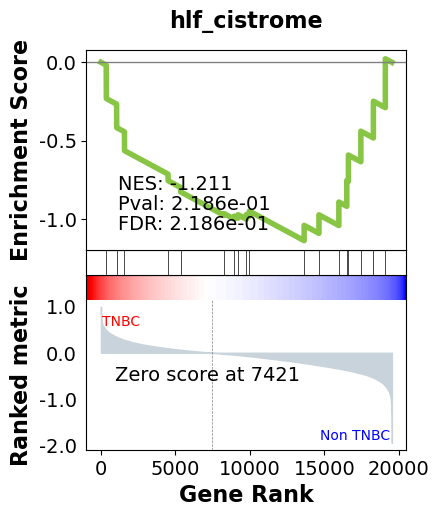

In [244]:
terms = result.res2d.Term
axs = result.plot(terms=terms[0]) # v1.0.5
# to make more control on the plot, use
# from gseapy import gseaplot
# gseaplot(rank_metric=pre_res.ranking, term=terms[0], ofname='your.plot.pdf', **pre_res.results[terms[0]])

In [251]:
 tumor_mask = metadata['tissue_type'] == 'Tumor'

In [255]:
tnbc_names[tumor_mask]

array(['TNBC', 'Non TNBC', 'Non TNBC', ..., 'TNBC', 'Non TNBC',
       'Non TNBC'], dtype='<U8')

In [256]:
result = gseapy.gsea(data=tpm[tumor_mask].T, gene_sets=genesets, cls=tnbc_names[tumor_mask])

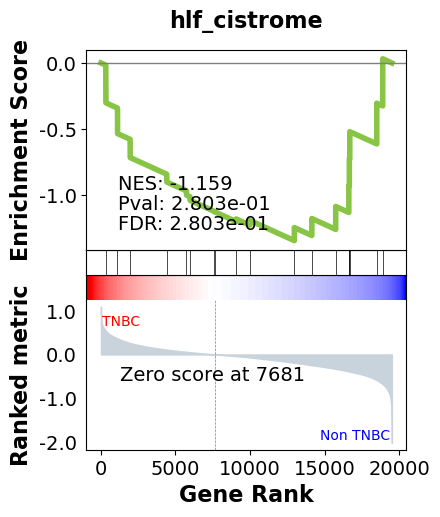

In [257]:
terms = result.res2d.Term
axs = result.plot(terms=terms[0])

In [259]:
metadata.loc[tnbc_mask]['tissue_type'].value_counts()

tissue_type
Tumor     197
Normal      6
Name: count, dtype: int64

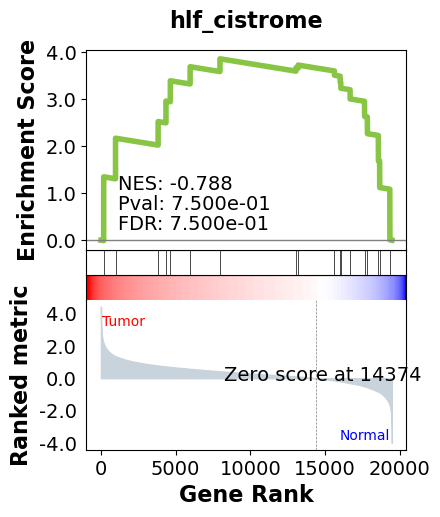

In [261]:
result = gseapy.gsea(data=tpm[tnbc_mask].T, gene_sets=genesets, cls=metadata.loc[tnbc_mask]['tissue_type'])
terms = result.res2d.Term
axs = result.plot(terms=terms[0])

In [263]:
ssgsea_results = gseapy.ssgsea(data=tpm.T,
                            gene_sets=genesets,
                            scale=True)

In [267]:
ssgsea_results.res2d

,Name,Term,ES,NES
0,8ca36e25-aabc-4bd9-9ced-a8d432ca0260,hlf_cistrome,2651.159971,1.069772
1,9dc09c86-c728-4bd9-b2b6-2d9962dad662,hlf_cistrome,2609.323197,1.052891
2,bdf5a2b7-f9cb-4668-9687-1db0541bdfe4,hlf_cistrome,2596.496333,1.047715
3,3e0cc1e4-0882-4e9b-9373-34bcbce097d7,hlf_cistrome,2569.459321,1.036805
4,d2659fd9-ac9a-4ab4-9d7c-50d9a16fc9b5,hlf_cistrome,2530.063868,1.020909
...,...,...,...,...
1217,7002e8cb-0d64-4d4b-a483-bf6dec3c2abb,hlf_cistrome,402.793794,0.162532
1218,148fc636-0b7b-4f10-b513-45edcf71a79e,hlf_cistrome,400.373523,0.161555
1219,1f224847-d745-4dc5-9338-4044413e8ec4,hlf_cistrome,380.509459,0.15354
1220,6e112ec6-1791-4764-8a62-7ad4dfea2d3b,hlf_cistrome,178.528595,0.072038


In [331]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

labels = ["low_immune" if i == 1 else "immune" for i in hierarchy.fcluster(
  hierarchy.linkage(distance.pdist(ssGSEA.T), method="average"),
  t=2,
  criterion="maxclust"
)]